In [43]:
from google.colab import drive
import os
# Install p7zip-full for handling .7z archives
!apt-get install -y p7zip-full
!pip install nibabel nilearn dicom2nifti
from scipy.ndimage import shift

from nilearn.image import clean_img, resample_to_img
import nibabel as nib
import os
import dicom2nifti
import nibabel as nib
from nilearn.image import clean_img, resample_to_img, smooth_img, resample_img
from nilearn.masking import compute_brain_mask
from nilearn.datasets import load_mni152_template
import numpy as np
from nilearn.decomposition import CanICA
from sklearn.preprocessing import StandardScaler
from nilearn.connectome import ConnectivityMeasure
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd
import glob
!pip install scikit-image
from skimage.registration import phase_cross_correlation



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.


In [44]:
# Mount Google Drive
drive.mount('/content/drive')

# Define paths
uploaded_file_path = '/content/drive/MyDrive/schizconnect_COBRE_images_22498.7z.001'
output_dir = '/content/extracted_data'
os.makedirs(output_dir, exist_ok=True)

print("Google Drive mounted and paths defined.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted and paths defined.


In [45]:
# Rename the file to .7z
renamed_file_path = uploaded_file_path.replace('.7z.001', '.7z')
os.rename(uploaded_file_path, renamed_file_path)

print(f"File renamed to: {renamed_file_path}")


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/schizconnect_COBRE_images_22498.7z.001' -> '/content/drive/MyDrive/schizconnect_COBRE_images_22498.7z'

In [46]:
# Extract the renamed .7z file
!7z x "/content/drive/MyDrive/schizconnect_COBRE_images_22498.7z" -o"/content/extracted_data"


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 1 file, 2277077170 bytes (2172 MiB)

Extracting archive: /content/drive/MyDrive/schizconnect_COBRE_images_22498.7z
--
Path = /content/drive/MyDrive/schizconnect_COBRE_images_22498.7z
Type = 7z
Physical Size = 2277077170
Headers Size = 13601
Method = LZMA2:24
Solid = +
Blocks = 2

  0%    
Would you like to replace the existing file:
  Path:     /content/extracted_data/COBRE/.bidsignore
  Size:     28 bytes (1 KiB)
  Modified: 2024-12-19 17:18:49
with the file from archive:
  Path:     COBRE/.bidsignore
  Size:     28 bytes (1 KiB)
  Modified: 2024-12-19 17:18:49
? (Y)es / (N)o / (A)lways / (S)kip all / A(u)to rename all /

In [47]:
# List the extracted files
'''for root, dirs, files in os.walk(output_dir):
    for file in files:
        print(os.path.join(root, file))'''

save_dir = '/content/fmri/corrected_nifti_data/'
os.makedirs(save_dir, exist_ok=True)

process_dir = '/content/fmri/processed_imaging_data/'
os.makedirs(process_dir, exist_ok=True)

spatial_maps_dir = '/content/fmri/spatial_maps_data/'
os.makedirs(spatial_maps_dir, exist_ok=True)
ica = CanICA(n_components=20, mask_strategy='background')
scaler = StandardScaler()

In [48]:
import os
import glob
import nibabel as nib
import numpy as np
from nilearn.image import resample_img, resample_to_img, smooth_img, clean_img
from nilearn.masking import compute_brain_mask
from nilearn.input_data import NiftiMasker
from nilearn.datasets import load_mni152_template
from skimage.registration import phase_cross_correlation
from scipy.ndimage import shift
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed
from nilearn.maskers import NiftiMasker
from nilearn.decomposition import CanICA

# Initialize scaler globally for reuse
scaler = StandardScaler()

import os
import glob
import nibabel as nib
import numpy as np
from nilearn.image import resample_to_img, smooth_img, clean_img
from nilearn.datasets import load_mni152_template, fetch_atlas_harvard_oxford
from nilearn.maskers import NiftiLabelsMasker
from nilearn.input_data import NiftiMasker
from sklearn.preprocessing import StandardScaler

# Load Harvard-Oxford Atlas (ROIs)
ho_atlas = fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')  # 96 cortical ROIs
ho_masker = NiftiLabelsMasker(labels_img=ho_atlas.maps, standardize=True, detrend=True,
                             low_pass=0.1, high_pass=0.01, t_r=2.0)

def extract_roi_features(nifti_img):
    """Extract mean ROI time-series features from fMRI data."""
    # Motion correction (use Nilearn's default instead of custom)
    # Note: If motion correction is already done, skip this step.
    cleaned_img = clean_img(nifti_img, detrend=True, standardize="zscore", t_r=2.0)

    # Smoothing
    smoothed_img = smooth_img(cleaned_img, fwhm=6)

    # Extract ROI time-series (shape: [time_points, n_rois])
    roi_time_series = ho_masker.fit_transform(smoothed_img)

    # Feature engineering: Temporal variability (mean/std across time)
    roi_means = np.mean(roi_time_series, axis=0)   # Mean activation per ROI
    roi_stds = np.std(roi_time_series, axis=0)     # Temporal variability per ROI

    # Combine into feature vector (shape: [n_samples, n_features])
    features = np.concatenate([roi_means, roi_stds])  # 96*2 = 192 features

    return features

# Main processing loop (simplified)
def process_nifti_files(nifti_files):
    features = []
    for i, nii_file in enumerate(nifti_files):
        print(f"Processing {i+1}/{len(nifti_files)}: {nii_file}")
        img = nib.load(nii_file)
        features.append(extract_roi_features(img))
    return np.array(features)

nifti_file_path = '/content/extracted_data/COBRE/sub*/ses*/func/*.nii.gz'

# Glob all files
nifti_files = glob.glob(nifti_file_path)
# Debugging step to print the files being processed
def is_empty_nifti(file_path):
    img = nib.load(file_path)
    return np.count_nonzero(img.get_fdata()) == 0  # Check if data is empty

nifti_files = glob.glob(nifti_file_path)
nifti_files = [f for f in nifti_files if not is_empty_nifti(f)]
def is_valid_nifti(file_path):
    try:
        nib.load(file_path)
        return True
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return False

nifti_files = glob.glob(nifti_file_path)
nifti_files = [f for f in nifti_files if is_valid_nifti(f)]

print("NIfTI files found:", nifti_files)

# Run the pipeline
fmri_features = process_nifti_files(nifti_files)

print("Preprocessing complete!")


[get_dataset_dir] Dataset found in /root/nilearn_data/fsl

NIfTI files found: ['/content/extracted_data/COBRE/sub-A00023246/ses-20110101/func/sub-A00023246_ses-20110101_task-rest_bold.nii.gz', '/content/extracted_data/COBRE/sub-A00019750/ses-20120101/func/sub-A00019750_ses-20120101_task-rest_bold.nii.gz', '/content/extracted_data/COBRE/sub-A00028404/ses-20110101/func/sub-A00028404_ses-20110101_task-rest_bold.nii.gz', '/content/extracted_data/COBRE/sub-A00018434/ses-20100101/func/sub-A00018434_ses-20100101_task-rest_bold.nii.gz', '/content/extracted_data/COBRE/sub-A00038624/ses-20130101/func/sub-A00038624_ses-20130101_task-rest_bold.nii.gz', '/content/extracted_data/COBRE/sub-A00028806/ses-20120101/func/sub-A00028806_ses-20120101_task-rest_bold.nii.gz', '/content/extracted_data/COBRE/sub-A00038441/ses-20130101/func/sub-A00038441_ses-20130101_task-rest_bold.nii.gz', '/content/extracted_data/COBRE/sub-A00009280/ses-20110101/func/sub-A00009280_ses-20110101_task-rest_run-02_bold.nii.gz', '/content/extracted_data/COBRE/sub-A00009280/ses-20110101/fun

In [49]:
print(fmri_features.shape)

(102, 96)


In [50]:
import zipfile
# Mount Google Drive
drive.mount('/content/drive')
# Define paths
uploaded_file_path = '/content/drive/MyDrive/dataverse_files.zip'
data_dir = '/content/extracted_eeg_data'
os.makedirs(data_dir, exist_ok=True)


# Extract the contents of the zip file
with zipfile.ZipFile(uploaded_file_path, 'r') as zip_ref:
    zip_ref.extractall(data_dir)
print("Google Drive mounted and paths defined.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted and paths defined.


In [9]:
!pip install mne
import os
import numpy as np
import mne
from mne.io import read_raw_edf
from mne.channels import make_standard_montage

# Constants
#DATA_DIR = "/path/to/edf/files"  # Update this
# Usage example
output_dir = "/content/eeg_features/"
os.makedirs(output_dir, exist_ok=True)

# Define electrode groups for brain regions (simplified)
REGIONS = {
    "frontal": ["Fp1", "Fp2", "F3", "F4", "F7", "F8"],
    "central": ["C3", "C4", "Cz"],
    "temporal": ["T3", "T4", "T5", "T6"],
    "parietal": ["P3", "P4", "Pz"],
    "occipital": ["O1", "O2"]
}

BANDS = {
    "delta": (0.5, 4),
    "theta": (4, 8),
    "alpha": (8, 12),
    "beta": (12, 30)
}

def extract_eeg_features(raw, label):
    """Extract region-specific spectral power (mean + std) per subject."""
    # Preprocess
    raw.pick_types(eeg=True)
    raw.set_montage(make_standard_montage("standard_1020"))  # Ensure electrode positions
    raw.filter(0.5, 30., fir_design='firwin')  # Skip gamma (noisy in EEG)

    # Extract epochs (non-overlapping 2s windows)
    epochs = mne.make_fixed_length_epochs(raw, duration=2, preload=True)

    # Compute PSD for all epochs
    psds, freqs = mne.time_frequency.psd_array_welch(
        epochs.get_data(),
        sfreq=raw.info["sfreq"],
        fmin=0.5,
        fmax=30,
        n_fft=256
    )

    # Aggregate features per region and band
    features = []
    for region, channels in REGIONS.items():
        # Find indices of channels in the region
        chan_indices = [i for i, ch in enumerate(raw.ch_names) if ch in channels]
        if not chan_indices:
            continue  # Skip if no channels found

        for band, (fmin, fmax) in BANDS.items():
            # Compute mean power across epochs and channels in the region
            band_mask = (freqs >= fmin) & (freqs < fmax)
            band_power = psds[:, chan_indices, :][..., band_mask].mean(axis=(0, 1, 2))
            band_std = psds[:, chan_indices, :][..., band_mask].std(axis=(0, 1, 2))

            features.extend([band_power, band_std])

    # Add label and save (one file per subject)
    features.append(label)
    output_file = os.path.join(output_dir, f"{os.path.splitext(file_name)[0]}_features.npy")
    np.save(output_file, np.array(features))

# Process files
for file_name in os.listdir(data_dir):
    if file_name.endswith(".edf"):
        file_path = os.path.join(data_dir, file_name)
        try:
            raw = read_raw_edf(file_path, preload=True)
            label = 0 if file_name.startswith("h") else 1  # Update label logic
            extract_eeg_features(raw, label)
        except Exception as e:
            print(f"Error processing {file_name}: {e}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 51.9 MB/s eta 0:00:00
Extracting EDF parameters from /content/extracted_eeg_data/h05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 236249  =      0.000 ...   944.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (6.604 s)

Not setting metadata
472 matching events found
No baseline correction app

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Extracting EDF parameters from /content/extracted_eeg_data/s13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 283749  =      0.000 ...  1134.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (6.604 s)

Not setting metadata
567 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 567 event

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Extracting EDF parameters from /content/extracted_eeg_data/h13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 241249  =      0.000 ...   964.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (6.604 s)

Not setting metadata
482 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 482 event

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Extracting EDF parameters from /content/extracted_eeg_data/s03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 240999  =      0.000 ...   963.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (6.604 s)

Not setting metadata
482 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 482 event

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Extracting EDF parameters from /content/extracted_eeg_data/h06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 232499  =      0.000 ...   929.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (6.604 s)

Not setting metadata
465 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 465 event

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Extracting EDF parameters from /content/extracted_eeg_data/s09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296249  =      0.000 ...  1184.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (6.604 s)

Not setting metadata
592 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 592 event

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Extracting EDF parameters from /content/extracted_eeg_data/s05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 222499  =      0.000 ...   889.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (6.604 s)

Not setting metadata
445 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 445 event

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Extracting EDF parameters from /content/extracted_eeg_data/h08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 227499  =      0.000 ...   909.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (6.604 s)

Not setting metadata
455 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 455 event

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Extracting EDF parameters from /content/extracted_eeg_data/h12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 224999  =      0.000 ...   899.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (6.604 s)

Not setting metadata
450 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 450 event

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Extracting EDF parameters from /content/extracted_eeg_data/s10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 212499  =      0.000 ...   849.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (6.604 s)

Not setting metadata
425 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 425 event

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Extracting EDF parameters from /content/extracted_eeg_data/s04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (6.604 s)

Not setting metadata
602 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 602 event

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Extracting EDF parameters from /content/extracted_eeg_data/s02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 286249  =      0.000 ...  1144.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (6.604 s)

Not setting metadata
572 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 572 event

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Extracting EDF parameters from /content/extracted_eeg_data/h11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 228749  =      0.000 ...   914.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (6.604 s)

Not setting metadata
457 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 457 event

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Extracting EDF parameters from /content/extracted_eeg_data/h14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 216249  =      0.000 ...   864.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (6.604 s)

Not setting metadata
432 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 432 event

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Extracting EDF parameters from /content/extracted_eeg_data/s14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 542499  =      0.000 ...  2169.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (6.604 s)

Not setting metadata
1085 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1085 eve

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


0 bad epochs dropped
Effective window size : 1.024 (s)
Extracting EDF parameters from /content/extracted_eeg_data/s11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 339999  =      0.000 ...  1359.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (6.604 s)

Not setting metadata
680 matching events found
No baseline correction applied
0 projection item

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Extracting EDF parameters from /content/extracted_eeg_data/s12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 271749  =      0.000 ...  1086.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (6.604 s)

Not setting metadata
543 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 543 event

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Extracting EDF parameters from /content/extracted_eeg_data/h02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 227499  =      0.000 ...   909.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (6.604 s)

Not setting metadata
455 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 455 event

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Extracting EDF parameters from /content/extracted_eeg_data/h03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 227499  =      0.000 ...   909.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (6.604 s)

Not setting metadata
455 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 455 event

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Extracting EDF parameters from /content/extracted_eeg_data/h01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 231249  =      0.000 ...   924.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (6.604 s)

Not setting metadata
462 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 462 event

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Extracting EDF parameters from /content/extracted_eeg_data/s06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 184999  =      0.000 ...   739.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (6.604 s)

Not setting metadata
370 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 370 event

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Extracting EDF parameters from /content/extracted_eeg_data/h07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 227499  =      0.000 ...   909.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (6.604 s)

Not setting metadata
455 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 455 event

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Extracting EDF parameters from /content/extracted_eeg_data/h10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 278749  =      0.000 ...  1114.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (6.604 s)

Not setting metadata
557 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 557 event

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Extracting EDF parameters from /content/extracted_eeg_data/s01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 211249  =      0.000 ...   844.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (6.604 s)

Not setting metadata
422 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 422 event

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Extracting EDF parameters from /content/extracted_eeg_data/h04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 231249  =      0.000 ...   924.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (6.604 s)

Not setting metadata
462 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 462 event

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Extracting EDF parameters from /content/extracted_eeg_data/s08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 227749  =      0.000 ...   910.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (6.604 s)

Not setting metadata
455 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 455 event

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Extracting EDF parameters from /content/extracted_eeg_data/s07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 336499  =      0.000 ...  1345.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (6.604 s)

Not setting metadata
673 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 673 event

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Extracting EDF parameters from /content/extracted_eeg_data/h09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 226249  =      0.000 ...   904.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (6.604 s)

Not setting metadata
452 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 452 event

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


In [51]:
import os
import numpy as np

def load_eeg_features(data_dir):
    """
    Load EEG features aggregated per subject
    Returns:
        eeg_features: np.array of shape [n_subjects, n_features]
        eeg_labels: np.array of shape [n_subjects]
    """
    subject_features = []
    subject_labels = []

    # Validate directory
    if not os.path.isdir(data_dir):
        raise ValueError(f"Invalid data directory: {data_dir}")

    # Load and process each file
    for file_name in sorted(os.listdir(data_dir)):
        if file_name.endswith("_features.npy"):
            try:
                file_path = os.path.join(data_dir, file_name)

                # Load data
                data = np.load(file_path)

                # Validate data shape
                if data.ndim != 1:
                    raise ValueError(f"Expected 1D array in {file_name}, got {data.ndim}D")

                # Separate features and labels
                features = data[:-1]  # All elements except last
                label = data[-1]      # Last element as label

                # Append to lists
                subject_features.append(features)
                subject_labels.append(label)

            except Exception as e:
                print(f"Skipping {file_name} due to error: {str(e)}")
                continue

    # Convert to numpy arrays
    eeg_features = np.array(subject_features)
    eeg_labels = np.array(subject_labels)

    # Final validation
    if len(eeg_features) == 0:
        raise ValueError("No valid EEG data found")

    if eeg_features.shape[0] != eeg_labels.shape[0]:
        raise ValueError("Feature/label count mismatch")

    print(f"Loaded {len(eeg_features)} subjects with {eeg_features.shape[1]} features")
    return eeg_features, eeg_labels


# Example usage
output_dir = "/content/eeg_features/"  # Update this path
eeg_features, eeg_labels = load_eeg_features(output_dir)

print("EEG features shape:", eeg_features.shape)  # [n_subjects, n_features]
print("Labels shape:", eeg_labels.shape)         # [n_subjects]
print("EEG features:", eeg_features)
print("Labels:", eeg_labels)

Loaded 28 subjects with 40 features
EEG features shape: (28, 40)
Labels shape: (28,)
EEG features: [[9.64514513e-12 6.68259240e-11 1.88306787e-12 ... 1.03547158e-10
  2.58333617e-12 5.75192972e-12]
 [8.83685374e-12 5.52428957e-11 3.62414265e-12 ... 4.88738960e-11
  7.05469819e-13 1.31157841e-12]
 [1.54635573e-11 1.15063181e-10 1.48160811e-12 ... 1.37697117e-11
  4.21298842e-13 8.64006113e-13]
 ...
 [4.82393962e-10 1.87712755e-08 6.10718240e-11 ... 1.97774280e-11
  1.75331303e-12 5.04037333e-12]
 [4.92128745e-11 2.37010504e-10 6.27759398e-12 ... 5.84621597e-12
  1.50778685e-12 4.13441580e-12]
 [9.72427550e-10 3.95595447e-08 1.26134334e-10 ... 1.02762230e-09
  1.92221607e-11 7.78010859e-10]]
Labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


In [76]:
import numpy as np
from sklearn.decomposition import PCA

# -------------------
# Data Preprocessing
# -------------------
def pad_or_truncate(data, target_size, pad_value=0):
    """Pads with zeros or truncates the dataset to match the required size."""
    current_size = data.shape[0]
    if current_size < target_size:
        pad_size = target_size - current_size
        pad_shape = (pad_size,) + data.shape[1:]  # Keep feature dimensions unchanged
        pad_values = np.full(pad_shape, pad_value)  # Pad with specified value
        return np.vstack((data, pad_values))  # Stack padded data
    return data[:target_size]  # Truncate if larger

# Reshape fMRI features (if needed)
#fmri_features = fmri_features.reshape(fmri_features.shape[0], -1)  # Ensure 2D shape

# Align fMRI features to EEG features' sample size
num_samples = eeg_features.shape[0]  # Use EEG features' sample size as the target

# Pad/truncate fMRI features to match EEG features' sample size
fmri_aligned = pad_or_truncate(fmri_features, num_samples)  # Pad/truncate fMRI features

# Align feature dimensions using PCA
n_components = eeg_features.shape[1]  # Match EEG features' dimensionality (40)
pca = PCA(n_components=n_components)
#fmri_reduced = pca.fit_transform(fmri_aligned)

# Verify shapes
print("EEG features shape:", eeg_features.shape)  # (28, 40)
print("EEG labels shape:", eeg_labels.shape)  # (28,)
print(eeg_labels)
print("fMRI features shape:", fmri_aligned.shape)  # (28, 40)

EEG features shape: (28, 40)
EEG labels shape: (28,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
fMRI features shape: (28, 40)


In [87]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
#export TORCH_USE_CUDA_DSA=1
# =====================
# 1. Data Preparation
# =====================

class DomainAdaptationDataset(Dataset):
    def __init__(self, source_features, source_labels, target_features):
        self.source_features = source_features
        self.source_labels = source_labels
        self.target_features = target_features

    def __len__(self):
        return max(len(self.source_features), len(self.target_features))

    def __getitem__(self, idx):
        source_idx = idx % len(self.source_features)
        target_idx = idx % len(self.target_features)

        return {
            'source': (self.source_features[source_idx], self.source_labels[source_idx]),
            'target': (self.target_features[target_idx], -1)  # Dummy label
        }

# =====================
# 2. DANN Architecture
# =====================

class GradientReversalLayer(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.alpha, None

class DANN(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super(DANN, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.task_classifier = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
        self.domain_classifier = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x, alpha=1.0):
        features = self.feature_extractor(x)
        task_output = self.task_classifier(features)
        reversed_features = GradientReversalLayer.apply(features, alpha)
        domain_output = self.domain_classifier(reversed_features)
        return task_output, domain_output

# =====================
# 3. Training Loop with Validation
# =====================

def train_dann(eeg_train, labels_train, fmri_features, eeg_val, labels_val, num_epochs=100, lambda_val=0.1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Standardize features
    scaler = StandardScaler()
    combined = np.vstack([eeg_train, fmri_features])
    scaler.fit(combined)

    eeg_train_scaled = scaler.transform(eeg_train)
    eeg_val_scaled = scaler.transform(eeg_val)
    fmri_scaled = scaler.transform(fmri_features)

    # Create dataset and dataloader
    dataset = DomainAdaptationDataset(
        source_features=eeg_train_scaled,
        source_labels=labels_train,
        target_features=fmri_scaled
    )
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    # Initialize model

    model = DANN(input_dim=eeg_train_scaled.shape[1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    task_loss_fn = nn.BCELoss()
    domain_loss_fn = nn.BCELoss()

    for epoch in range(num_epochs):
        model.train()
        total_task_loss = 0
        total_domain_loss = 0

        for batch in dataloader:
            # Source data (EEG)
            source_data, source_labels = batch['source']
            source_data = source_data.float().to(device)
            source_labels = source_labels.float().to(device)
            #source_labels = source_labels.to(device)

            # Target data (fMRI) - ignore labels
            target_data, _ = batch['target']
            target_data = target_data.float().to(device)

            # Combine data
            combined_data = torch.cat([source_data, target_data], dim=0)
            batch_size = source_data.size(0)

            # Domain labels
            domain_labels = torch.cat([
                torch.zeros(batch_size),
                torch.ones(combined_data.size(0) - batch_size)
            ]).to(device)

            # Forward pass
            task_preds, domain_preds = model(combined_data)

            # Split predictions
            source_task_preds = task_preds[:batch_size].squeeze()

            # Debugging checks

            assert torch.unique(source_labels).tolist() in [[0], [1], [0, 1]], "Invalid labels"
            assert not torch.isnan(source_data).any(), "NaN in source data"
            assert not torch.isinf(source_data).any(), "Inf in source data"
            assert source_task_preds.shape == source_labels.shape, "Shape mismatch"

            # Calculate losses
            task_loss = task_loss_fn(source_task_preds, source_labels)
            domain_loss = domain_loss_fn(domain_preds.squeeze(), domain_labels)
            total_loss = task_loss + lambda_val * domain_loss

            # Backpropagation
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            # Accumulate metrics
            total_task_loss += task_loss.item()
            total_domain_loss += domain_loss.item()

        # Print progress
        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}')
            print(f'Task Loss: {total_task_loss/len(dataloader):.4f}')
            print(f'Domain Loss: {total_domain_loss/len(dataloader):.4f}\n')

    return model, scaler
# =====================
# 4. Evaluation Functions
# =====================

def evaluate_metrics(model, scaler, features, labels, name):
    model.eval()
    with torch.no_grad():
        scaled_features = scaler.transform(features)
        features_tensor = torch.tensor(scaled_features).float().to(device)
        predictions, _ = model(features_tensor)
        preds = predictions.squeeze().cpu().numpy().round()

    acc = (preds == labels).mean()
    cm = confusion_matrix(labels, preds)
    report = classification_report(labels, preds, zero_division=0)

    print(f"\n{name} Evaluation:")
    print(f"Accuracy: {acc*100:.2f}%")
    print("Classification Report:")
    print(report)
    print("Confusion Matrix:")
    print(cm)

    return acc, cm, report

# =====================
# 5. Cross-Validation Pipeline
# =====================

if __name__ == "__main__":
    # Load data


    fmri_features = fmri_aligned
    fmri_labels = np.ones(len(fmri_features))

    # Initialize CV
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    results = []

    for fold_idx, (train_val_idx, test_idx) in enumerate(kf.split(eeg_features, eeg_labels)):
        print(f"\n=== Fold {fold_idx+1} ===")

        # Split into train/val/test
        eeg_train_val = eeg_features[train_val_idx]
        labels_train_val = eeg_labels[train_val_idx]
        eeg_test = eeg_features[test_idx]
        labels_test = eeg_labels[test_idx]

        # Further split train_val into train/val
#from sklearn.model_selection import StratifiedShuffleSplit

        # Initialize splitter (example: 5 splits with 20% test size)
        sss = StratifiedShuffleSplit(
            n_splits=5,       # Number of splits (like k-fold)
            test_size=0.2,    # Proportion of test set
            random_state=42   # Reproducibility
        )

        # Apply to your EEG data
        for fold, (train_idx, val_idx) in enumerate(
            sss.split(eeg_train_val, labels_train_val)
        ):
            print(f"\nFold {fold + 1}:")

            # Split data using indices
            eeg_train = eeg_train_val[train_idx]
            labels_train = labels_train_val[train_idx]
            eeg_val = eeg_train_val[val_idx]
            labels_val = labels_train_val[val_idx]

            print(f"Train class distribution: {np.unique(labels_train, return_counts=True)}")
            print(f"Val class distribution: {np.unique(labels_val, return_counts=True)}")

          # Train/evaluate model here

        # Train model
        model, scaler = train_dann(
            eeg_train, labels_train,
            fmri_features,
            eeg_val, labels_val,
            num_epochs=100,
            lambda_val=0.1
        )

        # Evaluate
        test_acc, test_cm, test_report = evaluate_metrics(model, scaler, eeg_test, labels_test, "EEG Test")
        fmri_acc, fmri_cm, fmri_report = evaluate_metrics(model, scaler, fmri_features, fmri_labels, "fMRI")

        results.append({
            'fold': fold_idx+1,
            'test_acc': test_acc,
            'fmri_acc': fmri_acc,
            'test_cm': test_cm,
            'fmri_cm': fmri_cm
        })

    # Final report
    print("\n=== Final Results ===")
    print(f"Mean EEG Test Accuracy: {np.mean([r['test_acc'] for r in results])*100:.2f}%")
    print(f"Mean fMRI Accuracy: {np.mean([r['fmri_acc'] for r in results])*100:.2f}%")
    print("\nAggregated EEG Test Confusion Matrix:")
    print(sum([r['test_cm'] for r in results]))
    print("\nAggregated fMRI Confusion Matrix:")
    print(sum([r['fmri_cm'] for r in results]))


=== Fold 1 ===

Fold 1:
Train class distribution: (array([0., 1.]), array([8, 9]))
Val class distribution: (array([0., 1.]), array([3, 2]))

Fold 2:
Train class distribution: (array([0., 1.]), array([9, 8]))
Val class distribution: (array([0., 1.]), array([2, 3]))

Fold 3:
Train class distribution: (array([0., 1.]), array([8, 9]))
Val class distribution: (array([0., 1.]), array([3, 2]))

Fold 4:
Train class distribution: (array([0., 1.]), array([8, 9]))
Val class distribution: (array([0., 1.]), array([3, 2]))

Fold 5:
Train class distribution: (array([0., 1.]), array([8, 9]))
Val class distribution: (array([0., 1.]), array([3, 2]))
Epoch 10/100
Task Loss: 0.6742
Domain Loss: 0.6874

Epoch 20/100
Task Loss: 0.6616
Domain Loss: 0.6872

Epoch 30/100
Task Loss: 0.6506
Domain Loss: 0.6872

Epoch 40/100
Task Loss: 0.6403
Domain Loss: 0.6869

Epoch 50/100
Task Loss: 0.6305
Domain Loss: 0.6867

Epoch 60/100
Task Loss: 0.6211
Domain Loss: 0.6862

Epoch 70/100
Task Loss: 0.6119
Domain Loss: 0.6

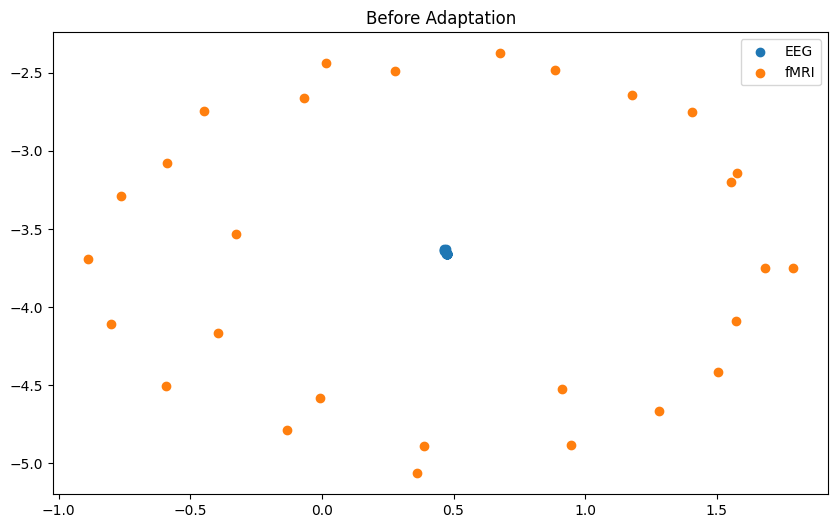

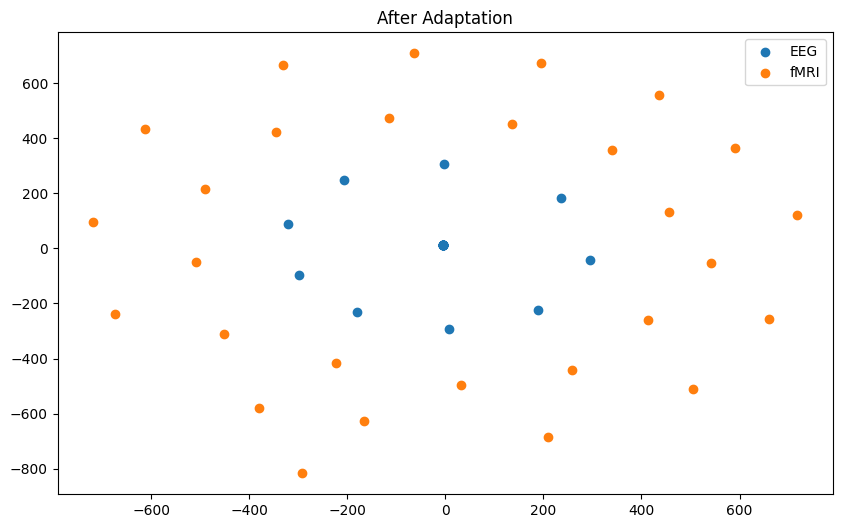

In [91]:
# Feature alignment visualization
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def plot_tsne(source, target, title):
    combined = np.vstack([source, target])
    labels = ["EEG"]*len(source) + ["fMRI"]*len(target)

    tsne = TSNE(n_components=2, random_state=42)
    embedded = tsne.fit_transform(combined)

    plt.figure(figsize=(10,6))
    plt.scatter(embedded[:len(source),0], embedded[:len(source),1], label="EEG")
    plt.scatter(embedded[len(source):,0], embedded[len(source):,1], label="fMRI")
    plt.title(title)
    plt.legend()

# Before DANN
plot_tsne(eeg_features, fmri_aligned, "Before Adaptation")

# After DANN
adapted_eeg = model.feature_extractor(torch.tensor(eeg_features).float().to(device)).detach().cpu().numpy()
adapted_fmri = model.feature_extractor(torch.tensor(fmri_aligned).float().to(device)).detach().cpu().numpy()
plot_tsne(adapted_eeg, adapted_fmri, "After Adaptation")